In [8]:
import numpy as np
import pandas as pd
from py2neo import Graph
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
# banksim_df = pd.read_csv("bs140513_032310.csv")
banksim_df = pd.read_csv("../data/bs140513_032310.csv")
# Retrieving the class attribute from the dataframe
labels = banksim_df['fraud']

'''
Removing unwanted columns
Since zipcodeOri and zipMerchant have the same value for all the rows, these columns are redundant
'''

feature_df = banksim_df.drop(['step', 'customer', 'zipcodeOri', 'zipMerchant', 'fraud'], axis=1)


# One hot encoding the categorical variables
feature_df = pd.get_dummies(feature_df, columns=['age', 'gender', 'category', 'merchant'])

# Standardizing the features
standard_scaler = StandardScaler()
scaled_df = pd.DataFrame(standard_scaler.fit_transform(feature_df), columns = feature_df.columns)


# Performing dimensionality reduction using PCA

# Limiting the number of components such that 95% of the variance is explained
pca = PCA(0.95, svd_solver='full')
scaled_df = pca.fit_transform(scaled_df)


# Training supervised learning models using intrinsic features from the dataset
k_fold = StratifiedKFold(n_splits=5, shuffle=False)

# Initialising the three supervised learning models
random_forest = RandomForestClassifier(max_depth=20, n_estimators=150)
svm = SVC(gamma="auto")
logistic_regression = LogisticRegression(solver='lbfgs', max_iter=5000)



Building Logistic Regression classifier with k=5 folds


C:\Users\vrana7\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\vrana7\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
C:\Users\vrana7\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be remove

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

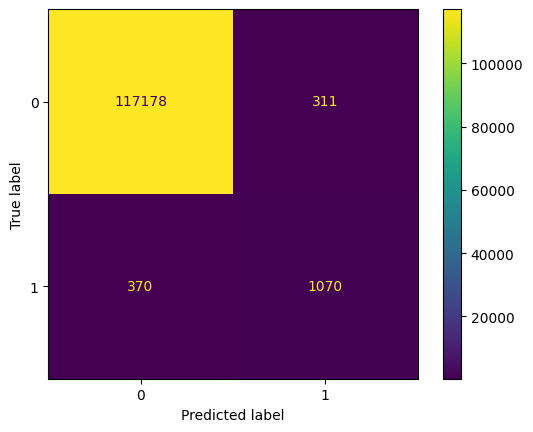

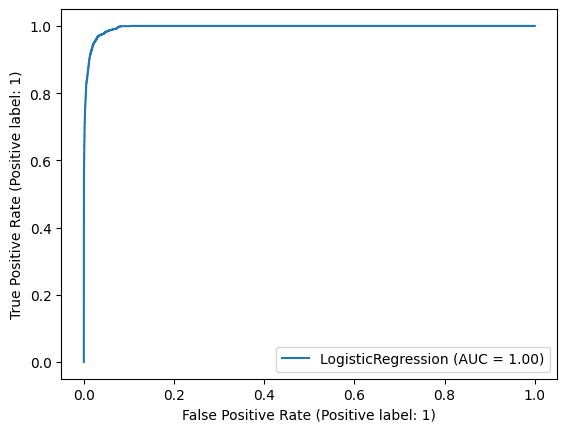

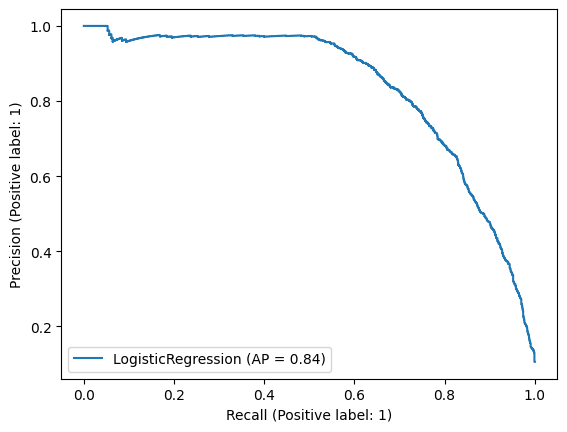



Building Logistic Regression classifier with k=5 folds


C:\Users\vrana7\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\vrana7\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
C:\Users\vrana7\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be remove

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

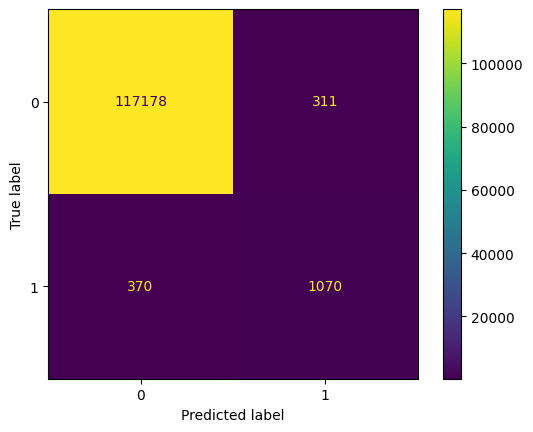

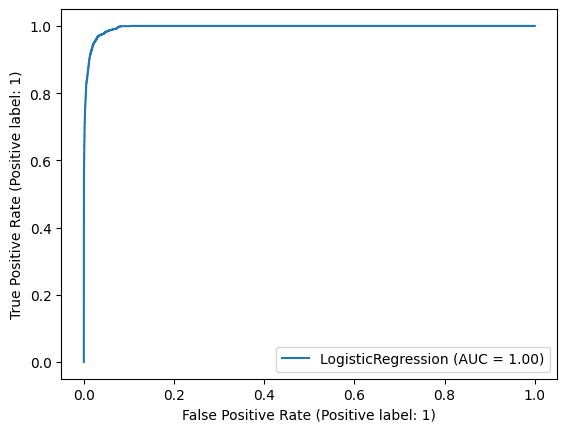

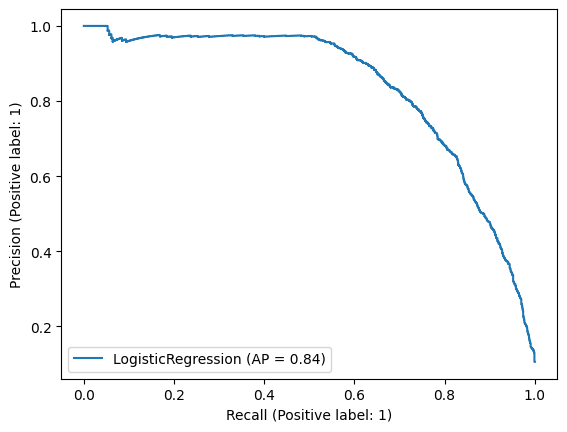

In [15]:
# Initialize lists to store the results of each fold
cm_list = []
roc_list = []
pr_list = []
feat_imp_list = []

print("\n\nBuilding Logistic Regression classifier with k=5 folds")

for train_index, test_index in k_fold.split(scaled_df, labels):

    X_train, X_test = scaled_df[train_index], scaled_df[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

    # Handling the imbalance in the dataset using SMOTE
    sm = SMOTE()
    X_after_smote, Y_after_smote = sm.fit_resample(X_train, y_train)

    # Training the logistic regression classifier
    clf = logistic_regression.fit(X_train, y_train)
    predictions = clf.predict(X_test)

    # Store the results for this fold
    cm = plot_confusion_matrix(clf, X_test, y_test)
    roc = plot_roc_curve(clf, X_test, y_test)
    pr = plot_precision_recall_curve(clf, X_test, y_test)
    feat_imp = pd.Series(clf.coef_[0], index=pd.DataFrame(X_train, columns=scaled_df.columns).columns).sort_values(ascending=False)[:10]

    # Append the results for this fold to the list
    cm_list.append(cm)
    roc_list.append(roc)
    pr_list.append(pr)
    feat_imp_list.append(feat_imp)

# Combine the results from each fold
cm_combined = cm_list[0]
roc_combined = roc_list[0].ax_
pr_combined = pr_list[0].ax_
feat_imp_combined = feat_imp_list[0]

for i in range(1, len(cm_list)):
    cm_combined = cm_combined + cm_list[i]
    roc_combined = roc_combined + roc_list[i].ax_
    pr_combined = pr_combined + pr_list[i].ax_
    feat_imp_combined = feat_imp_combined + feat_imp_list[i]

# Plot the combined results
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))

# Confusion matrix plot
cm_combined.ax_.set_title("Confusion Matrix")
cm_combined.ax_.set_xlabel("Predicted Label")
cm_combined.ax_.set_ylabel("True Label")
cm_combined.ax_.grid(False)

# ROC curve plot
roc_combined.set_title("Receiver Operating Characteristic (ROC) Curve")
roc_combined.set_xlabel("False Positive Rate")
roc_combined.set_ylabel("True Positive Rate")
roc_combined.grid(False)

# Precision-recall curve plot
pr_combined.set_title("Precision-Recall Curve")
pr_combined.set_xlabel("Recall")
pr_combined.set_ylabel("Precision")
pr_combined.grid(False)

# Feature importance plot
feat_imp_combined.plot(kind='bar', ax=ax[1][1])
ax[1][1].set_title("Top 10 Features by Importance")
ax[1][1].set_xlabel("Feature")
ax[1][1].set_ylabel("Importance")

plt.tight_layout()
plt.show()




Building Random Forest classifier with k=5 folds


C:\Users\vrana7\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\vrana7\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
C:\Users\vrana7\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be remove

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

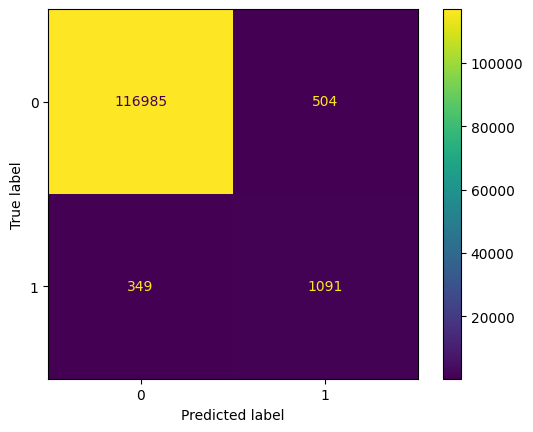

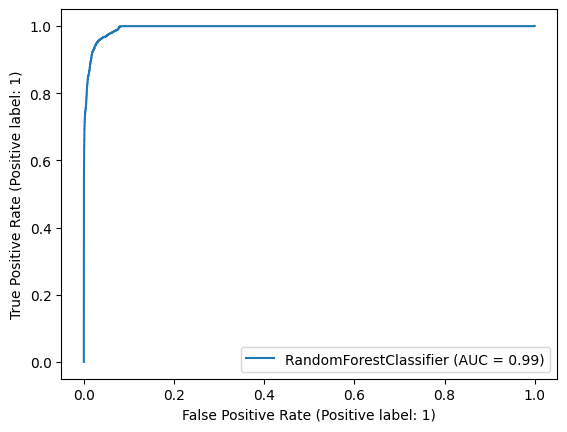

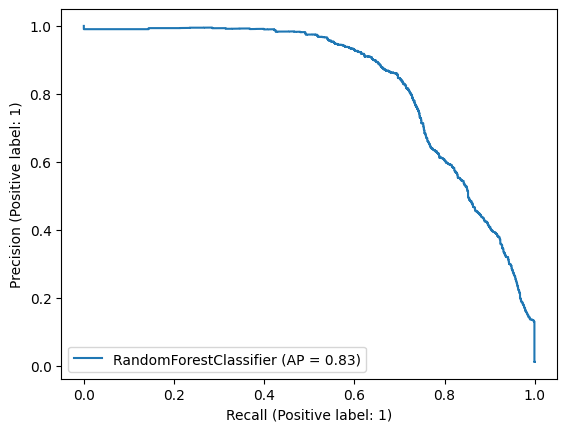

In [16]:
# Initialize lists to store the results of each fold
cm_list = []
roc_list = []
pr_list = []
feat_imp_list = []

print("\n\nBuilding Random Forest classifier with k=5 folds")

for train_index, test_index in k_fold.split(scaled_df, labels):

    X_train, X_test = scaled_df[train_index], scaled_df[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

    # Handling the imbalance in the dataset using SMOTE
    sm = SMOTE()
    X_after_smote, Y_after_smote = sm.fit_resample(X_train, y_train)

    # Training the random forest classifier
    clf = random_forest.fit(X_train, y_train)
    predictions = clf.predict(X_test)

    # Store the results for this fold
    cm = plot_confusion_matrix(clf, X_test, y_test)
    roc = plot_roc_curve(clf, X_test, y_test)
    pr = plot_precision_recall_curve(clf, X_test, y_test)
    feat_imp = pd.Series(clf.feature_importances_, index=scaled_df.columns).sort_values(ascending=False)[:10]

    # Append the results for this fold to the list
    cm_list.append(cm)
    roc_list.append(roc)
    pr_list.append(pr)
    feat_imp_list.append(feat_imp)

# Combine the results from each fold
cm_combined = cm_list[0]
roc_combined = roc_list[0].ax_
pr_combined = pr_list[0].ax_
feat_imp_combined = feat_imp_list[0]

for i in range(1, len(cm_list)):
    cm_combined = cm_combined + cm_list[i]
    roc_combined = roc_combined + roc_list[i].ax_
    pr_combined = pr_combined + pr_list[i].ax_
    feat_imp_combined = feat_imp_combined + feat_imp_list[i]

# Plot the combined results
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))

# Confusion matrix plot
cm_combined.ax_.set_title("Confusion Matrix")
cm_combined.ax_.set_xlabel("Predicted Label")
cm_combined.ax_.set_ylabel("True Label")
cm_combined.ax_.grid(False)

# ROC curve plot
roc_combined.set_title("Receiver Operating Characteristic (ROC) Curve")
roc_combined.set_xlabel("False Positive Rate")
roc_combined.set_ylabel("True Positive Rate")
roc_combined.grid(False)

# Precision-recall curve plot
pr_combined.set_title("Precision-Recall Curve")
pr_combined.set_xlabel("Recall")
pr_combined.set_ylabel("Precision")
pr_combined.grid(False)

# Feature importance plot
feat_imp_combined.plot(kind='bar', ax=ax[1][1])
ax[1][1].set_title("Top 10 Features by Importance")
ax[1][1].set_xlabel("Feature")
ax[1][1].set_ylabel("Importance")

plt.tight_layout()
plt.show()


In [ ]:
# Initialize lists to store the results of each fold
cm_list = []
roc_list = []
pr_list = []
feat_imp_list = []

print("\n\nBuilding SVM classifier with k=5 folds")

for train_index, test_index in k_fold.split(scaled_df, labels):

    X_train, X_test = scaled_df[train_index], scaled_df[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

    # Handling the imbalance in the dataset using SMOTE
    sm = SMOTE()
    X_after_smote, Y_after_smote = sm.fit_resample(X_train, y_train)

    # Training the SVM classifier
    clf = svm.fit(X_train, y_train)
    predictions = clf.predict(X_test)

    # Store the results for this fold
    cm = plot_confusion_matrix(clf, X_test, y_test)
    roc = plot_roc_curve(clf, X_test, y_test)
    pr = plot_precision_recall_curve(clf, X_test, y_test)
    feat_imp = pd.Series(clf.coef_[0], index=scaled_df.columns).sort_values(ascending=False)[:10]

    # Append the results for this fold to the list
    cm_list.append(cm)
    roc_list.append(roc)
    pr_list.append(pr)
    feat_imp_list.append(feat_imp)

# Combine the results from each fold
cm_combined = cm_list[0]
roc_combined = roc_list[0].ax_
pr_combined = pr_list[0].ax_
feat_imp_combined = feat_imp_list[0]

for i in range(1, len(cm_list)):
    cm_combined = cm_combined + cm_list[i]
    roc_combined = roc_combined + roc_list[i].ax_
    pr_combined = pr_combined + pr_list[i].ax_
    feat_imp_combined = feat_imp_combined + feat_imp_list[i]

# Plot the combined results
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))

# Confusion matrix plot
cm_combined.ax_.set_title("Confusion Matrix")
cm_combined.ax_.set_xlabel("Predicted Label")
cm_combined.ax_.set_ylabel("True Label")
cm_combined.ax_.grid(False)

# ROC curve plot
roc_combined.set_title("Receiver Operating Characteristic (ROC) Curve")
roc_combined.set_xlabel("False Positive Rate")
roc_combined.set_ylabel("True Positive Rate")
roc_combined.grid(False)

# Precision-recall curve plot
pr_combined.set_title("Precision-Recall Curve")
pr_combined.set_xlabel("Recall")
pr_combined.set_ylabel("Precision")
pr_combined.grid(False)

# Feature importance plot
feat_imp_combined.plot(kind='bar', ax=ax[1][1])
ax[1][1].set_title("Top 10 Features by Importance")
ax[1][1].set_xlabel("Feature")
ax[1][1].set_ylabel("Importance")

plt.tight_layout()
plt.show()




Building SVM classifier with k=5 folds
